# Modélisation des demandes de crédits avec Random Forest

## Chargement des données d'entraînement et de test

In [1]:
import sys
sys.path.insert(0, "/home/cyril/openclassrooms/projets/P7/P7_baudrillart_cyril_V2/custom_functions")

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import time
import matplotlib.pyplot as plt
from model_analysis import plot_confusion_matrix, plot_roc_curve

In [3]:
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, LassoCV
from sklearn.model_selection import train_test_split, KFold
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.metrics import (f1_score, recall_score, roc_auc_score, precision_score, r2_score,
                            accuracy_score, roc_curve, auc)
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [4]:
# Chargement des données intégrales imputées
X = pd.read_csv('../data_models/X_top10_imputed.csv', index_col=0)

In [5]:
X.shape

(292062, 12)

In [6]:
X.head()

,EXT_SOURCE_3,EXT_SOURCE_2,PREV_DAYS_DECISION_MIN,CODE_GENDER,DAYS_EMPLOYED,PREV_APP_CREDIT_PERC_MIN,INSTAL_DPD_MAX,AMT_CREDIT,DAYS_BIRTH,FLAG_OWN_CAR,NAME_EDUCATION_TYPE_Higher_education,TARGET
0,0.574447,0.092250,1229.0,1.0,335.0,0.627786,0.0,508495.5,20255.0,0.0,0.0,0.0
1,0.746300,0.779680,2688.0,1.0,5862.0,0.906651,0.0,728460.0,21989.0,0.0,0.0,0.0
2,0.159520,0.475448,1632.0,1.0,224.0,0.938086,0.0,239850.0,25054.0,0.0,0.0,0.0
3,0.456110,0.698863,2500.0,0.0,7093.0,0.000000,22.0,450000.0,18862.0,0.0,1.0,0.0
4,0.761026,0.658295,2608.0,1.0,224.0,0.000000,27.0,1350000.0,21817.0,1.0,0.0,0.0


In [7]:
# Création de la target
y = X.TARGET

In [8]:
# Supprimer la target des features
X = X.drop(columns='TARGET')

In [9]:
# Comptage des classes
Counter(y)

Counter({0.0: 268139, 1.0: 23923})

La classe 1 est minoritaire.

In [10]:
# train-test split with stratification on the class we are trying to predict
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2, stratify=y)

In [11]:
Counter(y_test)

Counter({0.0: 80442, 1.0: 7177})

In [12]:
Counter(y_test)[0]/Counter(y_test)[1]

11.208304305420093

In [13]:
Counter(y_train)[0]/Counter(y_train)[1]

11.208467693777619

## RandomForest

### Undersampling

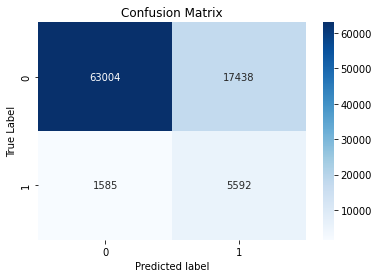

              precision    recall  f1-score   support

         0.0       0.98      0.78      0.87     80442
         1.0       0.24      0.78      0.37      7177

    accuracy                           0.78     87619
   macro avg       0.61      0.78      0.62     87619
weighted avg       0.92      0.78      0.83     87619

ROC AUC Score: 0.78


In [35]:
# Imputation des données manquantes et randomforest
steps = [('oversample', RandomUnderSampler(random_state=42)),
         ('model', RandomForestClassifier())]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

### Oversampling

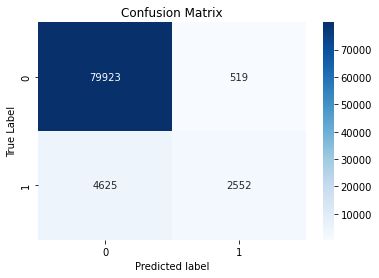

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     80442
         1.0       0.83      0.36      0.50      7177

    accuracy                           0.94     87619
   macro avg       0.89      0.67      0.73     87619
weighted avg       0.94      0.94      0.93     87619

ROC AUC Score: 0.67


In [19]:
# Imputation des données manquantes et randomforest
steps = [('oversample', RandomOverSampler(random_state=42)),
         ('model', RandomForestClassifier())]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

### SMOTE

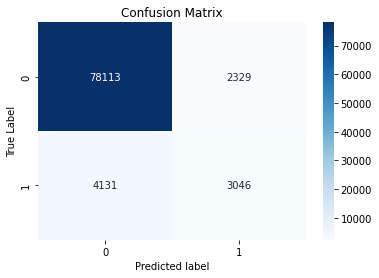

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     80442
         1.0       0.57      0.42      0.49      7177

    accuracy                           0.93     87619
   macro avg       0.76      0.70      0.72     87619
weighted avg       0.92      0.93      0.92     87619

ROC AUC Score: 0.70


In [20]:
# Imputation des données manquantes avec SMOTE et xgboost
oversample_model = SMOTE(sampling_strategy='auto', k_neighbors=5)

steps = [('sampling', oversample_model),
         ('model', RandomForestClassifier())]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

### Utilisation du paramètre 'class_weight'

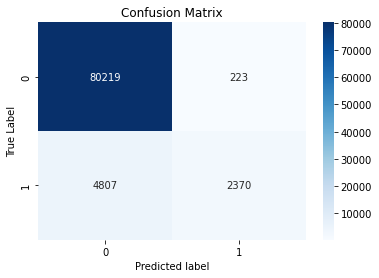

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     80442
         1.0       0.91      0.33      0.49      7177

    accuracy                           0.94     87619
   macro avg       0.93      0.66      0.73     87619
weighted avg       0.94      0.94      0.93     87619

ROC AUC Score: 0.66


In [21]:
# Imputation des données manquantes et randomforest
steps = [('model', RandomForestClassifier(class_weight='balanced'))]

pipeline = Pipeline(steps=steps)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

## Optimisation des hyperparamètres Random Forest

### Recherche sur grille

In [22]:
pipeline

Pipeline(steps=[('model', RandomForestClassifier(class_weight='balanced'))])

In [23]:
# Paramètre utilisés
pipeline['model'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Les paramètres les plus importants sont  
- n_estimator: nombre d'arbres de la forêt  
- max_features: nombre max de features considérées pour séparer un noeud  
- max_depth: nombre max de niveaux pour chaque arbre  
- min_samples_split: nombre max d'échantillons par noeud avant split  
- min_samples_leaf: nombre max d'échantillons par feuille  
- bootstrap: méthode utilisées pour l'échantillonnage (avec ou sans remise)

Afin de réduire les temps de calcul, il est recommandé d'utiliser RandomizedSearchCV qui ne va pas tester toutes les combinaisons comme GridSearchCV

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'model__n_estimators': n_estimators,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}
print(random_grid)

In [51]:
import time

# On commence par optimiser la ROC AUC

# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
# utilisation de la cross validation
cv = StratifiedKFold(n_splits=3)
rf_random = RandomizedSearchCV(estimator = pipeline,
                               param_distributions = random_grid,
                               cv = cv,
                               scoring='roc_auc',
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)# Fit the random search model

In [52]:
%%time
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [53]:
rf_random.best_params_

AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'

In [71]:

rf_random.best_score_

0.7342774445616742

In [ ]:
Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('oversample', RandomUnderSampler(random_state=42)),
                ('model', RandomForestClassifier(class_weight='balanced'))])



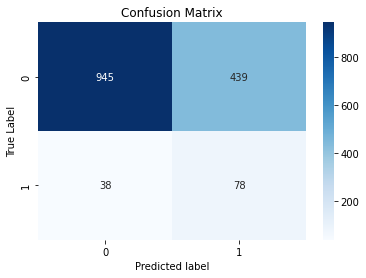

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.80      1384
         1.0       0.15      0.67      0.25       116

    accuracy                           0.68      1500
   macro avg       0.56      0.68      0.52      1500
weighted avg       0.90      0.68      0.76      1500

ROC AUC Score: 0.68


In [72]:
y_pred = rf_random.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

In [73]:
import time
# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = pipeline,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 3,
                               scoring='recall',
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)# Fit the random search model

In [74]:
%%time
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1550; total time=  12.2s
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=650; total time=   4.9s
[CV] END model__bootstrap=True, model__max_depth=35, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1550; total time=   9.8s
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=650; total time=   4.1s
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=200; total time=   1.2s
[CV] END model__bootstrap=True, model__m

[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=650; total time=   5.3s
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1550; total time=  13.8s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   1.3s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1550; total time=   9.5s
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=200; total time=   1.2s
[CV] END model__bootstrap=True, model__max_depth=None, model__max_features=auto, model__min_sample

[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1550; total time=  12.2s
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=650; total time=   5.2s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   1.3s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=200; total time=   1.3s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1550; total time=   9.6s
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_lea

[CV] END model__bootstrap=False, model__max_depth=60, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=650; total time=   5.2s
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=650; total time=   5.9s
[CV] END model__bootstrap=False, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1550; total time=  12.9s
[CV] END model__bootstrap=True, model__max_depth=85, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1550; total time=   9.8s
[CV] END model__bootstrap=False, model__max_depth=85, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1100; total time=   9.3s
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_

[CV] END model__bootstrap=False, model__max_depth=60, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=650; total time=   5.2s
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=650; total time=   5.3s
[CV] END model__bootstrap=False, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1550; total time=  13.3s
[CV] END model__bootstrap=True, model__max_depth=85, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1550; total time=  10.0s
[CV] END model__bootstrap=False, model__max_depth=110, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1100; total time=   8.7s
[CV] END model__bootstrap=False, model__max_depth=60, model__max_features=auto, model__min_samples_

[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1550; total time=   9.7s
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=1550; total time=  13.3s
[CV] END model__bootstrap=True, model__max_depth=85, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=1550; total time=  10.1s
[CV] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1550; total time=   9.9s
[CV] END model__bootstrap=False, model__max_depth=35, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000; total time=  17.9s
[CV] END model__bootstrap=False, model__max_depth=110, model__max_features=sqrt, model__min_sample

[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=650; total time=   4.8s
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=650; total time=   5.0s
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=650; total time=   5.6s
[CV] END model__bootstrap=False, model__max_depth=35, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000; total time=  17.0s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1550; total time=   9.7s
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=auto, model__min_samples

[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1550; total time=  11.7s
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1550; total time=  13.0s
[CV] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   1.3s
[CV] END model__bootstrap=False, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1100; total time=   9.1s
[CV] END model__bootstrap=False, model__max_depth=85, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1100; total time=   9.2s
[CV] END model__bootstrap=True, model__max_depth=35, model__max_features=sqrt, model__min_samp

CPU times: user 3.63 s, sys: 132 ms, total: 3.76 s
Wall time: 1min 16s


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('impute',
                                              SimpleImputer(strategy='median')),
                                             ('oversample',
                                              RandomUnderSampler(random_state=42)),
                                             ('model',
                                              RandomForestClassifier(class_weight='balanced'))]),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'model__bootstrap': [True, False],
                                        'model__max_depth': [10, 35, 60, 85,
                                                             110, None],
                                        'model__max_features': ['auto', 'sqrt'],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                                   

In [77]:
rf_random.best_params_

{'model__n_estimators': 1550,
 'model__min_samples_split': 10,
 'model__min_samples_leaf': 4,
 'model__max_features': 'sqrt',
 'model__max_depth': 10,
 'model__bootstrap': True}

[CV] END model__bootstrap=False, model__max_depth=110, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000; total time=   7.0s
[CV] END model__bootstrap=False, model__max_depth=35, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1550; total time=   5.1s
[CV] END model__bootstrap=False, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000; total time=   6.5s
[CV] END model__bootstrap=False, model__max_depth=60, model__max_features=auto, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=650; total time=   2.0s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=2000; total time=   6.4s
[CV] END model__bootstrap=False, model__max_depth=60, model__max_features=sqrt, model__min_sampl

[CV] END model__bootstrap=False, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=1100; total time=   3.5s
[CV] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=2, model__n_estimators=1550; total time=   5.1s
[CV] END model__bootstrap=True, model__max_depth=85, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=5, model__n_estimators=1100; total time=   3.5s
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=650; total time=   2.1s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=2000; total time=   6.4s
[CV] END model__bootstrap=False, model__max_depth=60, model__max_features=sqrt, model__min_samples

[CV] END model__bootstrap=True, model__max_depth=None, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=200; total time=   0.7s
[CV] END model__bootstrap=False, model__max_depth=85, model__max_features=sqrt, model__min_samples_leaf=4, model__min_samples_split=5, model__n_estimators=1550; total time=   4.8s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=auto, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=650; total time=   2.1s
[CV] END model__bootstrap=False, model__max_depth=60, model__max_features=auto, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=200; total time=   0.6s
[CV] END model__bootstrap=False, model__max_depth=35, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=2, model__n_estimators=2000; total time=   6.5s
[CV] END model__bootstrap=True, model__max_depth=110, model__max_features=auto, model__min_samples_l

[CV] END model__bootstrap=False, model__max_depth=60, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=5, model__n_estimators=1100; total time=   3.4s
[CV] END model__bootstrap=True, model__max_depth=None, model__max_features=auto, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=1550; total time=   5.0s
[CV] END model__bootstrap=False, model__max_depth=85, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=10, model__n_estimators=1100; total time=   3.8s
[CV] END model__bootstrap=False, model__max_depth=85, model__max_features=auto, model__min_samples_leaf=4, model__min_samples_split=10, model__n_estimators=2000; total time=   6.1s
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=1, model__min_samples_split=10, model__n_estimators=650; total time=   2.1s
[CV] END model__bootstrap=False, model__max_depth=None, model__max_features=sqrt, model__min_sam

In [75]:
rf_random.best_score_

0.6777777777777777

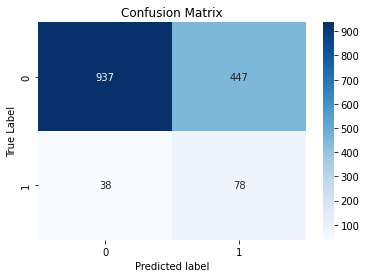

              precision    recall  f1-score   support

         0.0       0.96      0.68      0.79      1384
         1.0       0.15      0.67      0.24       116

    accuracy                           0.68      1500
   macro avg       0.55      0.67      0.52      1500
weighted avg       0.90      0.68      0.75      1500

ROC AUC Score: 0.67


In [76]:
y_pred = rf_random.predict(X_test)
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_pred)

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

https://medium.com/@DavidArdagh/a-guided-approach-to-using-machine-learning-for-cricket-wicket-prediction-27bbf938f439

https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/

In [78]:
# Calcul des probabilités d'appartenir à la classe 1
y_scores = rf_random.predict_proba(X_test)[:, 1]

Training multiple models on train data: https://www.kaggle.com/code/niteshiitr/auc-roc-0-947-using-smote-rf-gridsearchcv/notebook